## Importando Bibliotecas

In [1]:
from collections import defaultdict
from pacman.actions import Actions
from pacman.env import PacmanEnv
from pacman.agents import Agent

import matplotlib.pyplot as plt
from time import perf_counter
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme('notebook', style= 'darkgrid')
plt.style.use('dark_background')

pygame 2.5.2 (SDL 2.28.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Reinforcement Learning (MO436)

Autores:

**Aline Cavalca Caravlho Soares de Azevedo** (RA: )

**Beatriz Cardoso Nascimento**               (RA: )

**Daniel Gardin Gratti**                     (RA: 214729)

**Guilhermo de Luiggi Mocelim de Oliveira** (RA: )


## Introdução

Reinforcement Learning é um paradigma de Inteligência Artificial baseada em controle

In [2]:
deterministic_env = PacmanEnv.contourDanger(4, ghost_names= "RobustGhost")
stochastic_env    = PacmanEnv.contourDanger(4, ghost_names= "StochasticRobustGhost")

In [3]:
stochastic_env.reset()

% % % % % %
% .       %
%   G     %
%     P   %
%         %
% % % % % %
Score: 0


(((3, 2), (0.0,), ((2, 3),), ('No action',), (0,)), False)

In [4]:
def plot_episodes(history, metrics, smooth=101, alpha=0.4):
    if isinstance(metrics, str):
        metrics = [metrics]

    n_metrics = len(metrics)

    fig, axs = plt.subplots(ncols=n_metrics,figsize=(8*n_metrics, 5))

    axs = np.atleast_1d(axs)
    
    colors = ['#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#c51b8a', '#7a0177']

    for ax, metric in zip(axs, metrics):
        for (n0,hist), color in zip(history.items(),colors):
            episodes = np.array(hist[metric])

            ax.plot(episodes, alpha=alpha)

            padded_episodes = np.pad(episodes, (smooth//2,smooth//2), 'edge')
            smooth_episodes = np.convolve(padded_episodes, np.ones(smooth)/smooth, mode='valid')

            ax.plot(smooth_episodes, linewidth=1, color=color, label= n0)

        ax.set_title(f"{metric.capitalize()} during training")
        ax.set_ylabel(metric)
        ax.set_xlabel("episode")
        ax.legend()

    return fig, axs

In [5]:
class EpsilonGreedyQAgent(Agent):
    """
    Agent with internal Q table and epsilon-greedy policy. Can learn from a control algorithm.
    """

    def __init__(self):
        self.Qtable = defaultdict(lambda : {action: 0. for action in Actions.actions})
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            # Realiza um passo guloso de acordo com os valores Q aprendidos
            action, _ = self.max_Q(state)

        else:
            # Amostra uma ação aleatória dentre as ações disponíveis
            action = Actions.sample()

        return action


    def Q(self, state, action):
        return self.Qtable[state][action]
    

    def max_Q(self, state):
        action_values = self.Qtable[state]

        action = max(action_values, key=lambda k : action_values[k])

        return action, action_values[action]


    def update_Q(self, state, action, alpha, error):
        self.Qtable[state][action] += alpha * error


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.Qtable.clear()

In [ ]:
metrics = ["Mean reward", "Mean length", "Mean winrate", "Training time"]

configs = ["Environment", "Policy", "Algorithm"]

index = pd.MultiIndex(levels=[[] for _ in range(len(configs))], codes=[[] for _ in range(len(configs))], names=configs)
results = pd.DataFrame(index=index, columns=metrics)

In [ ]:
def evaluate(env, policy, control, parameter, values, n_episodes=10000):
    history = {}

    df = pd.DataFrame(columns=metrics)

    for value in values:
        performances = dict(zip(metrics, [0.] * len(metrics)))

        setattr(control, parameter, value)

        initial_time = perf_counter()
        _, hist = control.train(policy, n_episodes)
        performances["Training time"] = perf_counter() - initial_time

        history[value] = hist

        n_repetitions = 100 if env.is_stochastic() else 1

        for _ in range(n_repetitions):
            env.run_policy(policy)

            performances["Mean reward"]  += env.get_score()
            performances["Mean length"]  += env.current_step
            performances["Mean winrate"] += int(env.is_win())

        performances["Mean reward"]  /= n_repetitions
        performances["Mean length"]  /= n_repetitions
        performances["Mean winrate"] /= n_repetitions


        df.loc[value, :] = performances

        policy.reset()

    return history, df

### Monte Carlo

In [6]:
class MonteCarloControl:
    def __init__(self, env, gamma, alpha=None, N0=1):
        self.env   = env
        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0
    

    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):

            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0
            n_steps           = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)

                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1
               
                cumulative_reward = (self.gamma * cumulative_reward) + reward

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha
                error = (cumulative_reward - policy.Q(state, action))

                policy.update_Q(state, action, alpha, error)

                cumulative_error += abs(error)

                state  = next_state
            
            mean_error = cumulative_error / self.env.current_step

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(mean_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())
        
        return policy, history

In [9]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    MonteCarloControl(deterministic_env.set_render(None), 0.99),
    "N0",
    [0.01, 0.1, 1, 10, 100]
)

performance

  1%|          | 52/10000 [00:00<00:45, 217.69it/s]

100%|██████████| 10000/10000 [00:13<00:00, 732.90it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.01,45.0,5.0,1.0,29.486002
0.10,-102.0,101.0,0.0,109.480991
1.00,45.0,5.0,1.0,11.85696
10.00,45.0,5.0,1.0,11.390406
100.00,39.0,11.0,1.0,13.645552


In [10]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "Monte Carlo"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,45.0,5.0,1.0,29.486002


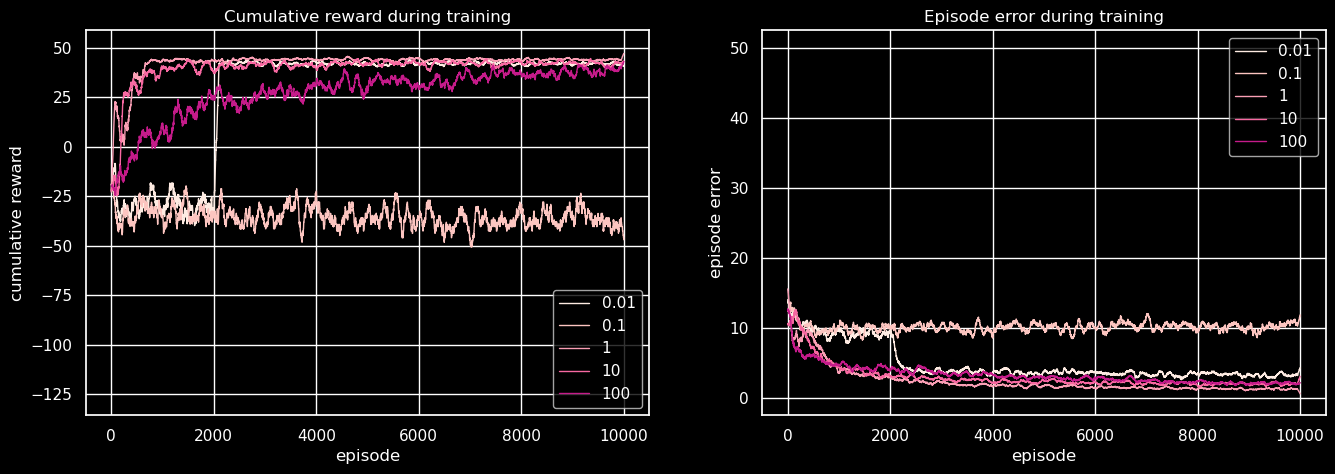

In [11]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [12]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    MonteCarloControl(stochastic_env.set_render(None), 0.99),
    "N0",
    [0.01, 0.1, 1, 10, 100]
)

performance

100%|██████████| 10000/10000 [00:18<00:00, 534.44it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.01,3.6,19.28,0.68,19.78562
0.10,31.4,16.82,1.0,23.414667
1.00,34.31,14.64,0.99,21.295272
10.00,28.86,19.0,1.0,18.92779
100.00,38.02,11.98,1.0,18.712572


In [13]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "Monte Carlo"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,45.0,5.0,1.0,29.486002
Stochastic,Classic,Monte Carlo,38.02,11.98,1.0,18.712572


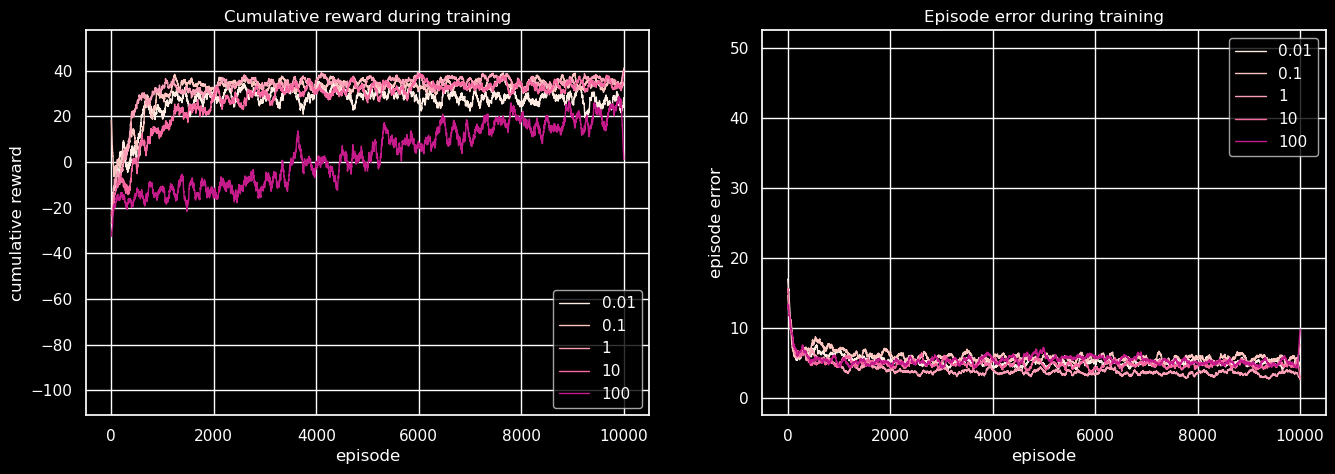

In [14]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

### Q-Learning

In [30]:
class QLearning():
    def __init__(self, env, gamma, alpha=1., N0=1):
        self.env   = env
        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0

    
    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):
            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                _, Qmax = policy.max_Q(next_state)

                td_error = reward + self.gamma * Qmax - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = self.alpha/Ntable[state][action]

                policy.update_Q(state, action, alpha, td_error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())

        return policy, history

In [16]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    QLearning(deterministic_env.set_render(None), 0.99),
    "gamma",
    [0, 0.2, 0.4, 0.6, 0.8, 0.99]
)

performance

100%|██████████| 10000/10000 [00:06<00:00, 1559.01it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.00,-101.0,101.0,0.0,115.423029
0.20,-101.0,101.0,0.0,40.40323
0.40,45.0,5.0,1.0,6.692488
0.60,43.0,7.0,1.0,6.580939
0.80,45.0,5.0,1.0,6.247492
0.99,45.0,5.0,1.0,6.417432


In [41]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "Q-Learning"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning        42.46        7.54          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning      10.721102  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

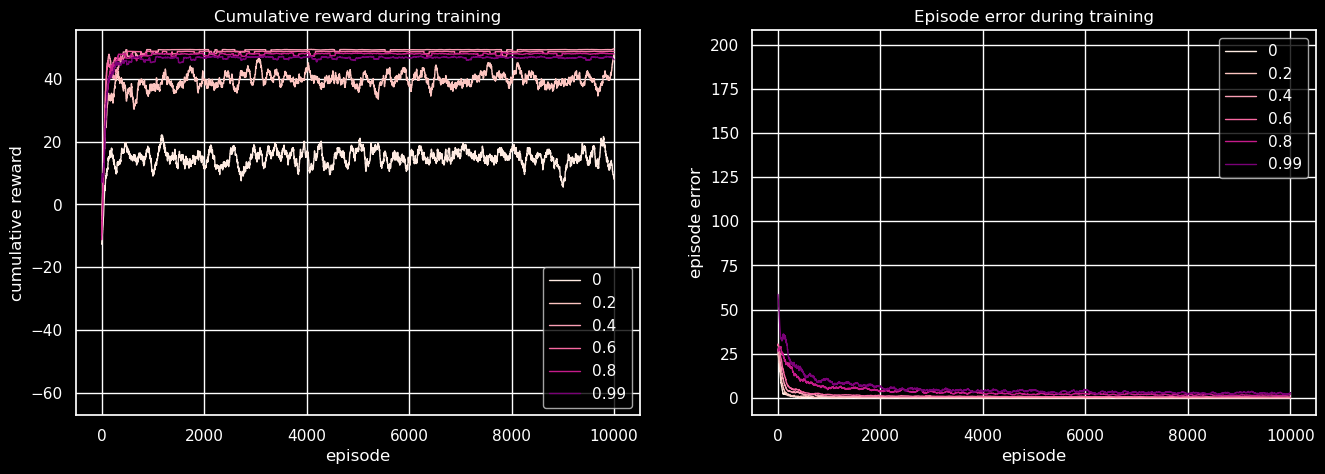

In [18]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [20]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    QLearning(stochastic_env.set_render(None), 0.99),
    "gamma",
    [0, 0.2, 0.4, 0.6, 0.8, 0.99]
)

performance

100%|██████████| 10000/10000 [00:08<00:00, 1111.69it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.00,-101.92,101.0,0.0,104.177259
0.20,38.48,8.94,0.96,13.420765
0.40,37.54,11.26,0.98,9.926431
0.60,36.86,8.26,0.93,8.32596
0.80,37.41,8.52,0.94,8.509096
0.99,39.72,9.69,1.0,8.997007


In [21]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "Q-Learning"), :] = performance.iloc[best]

results

,,,Mean reward,Mean length,Mean winrate,Training time
Environment,Policy,Algorithm,,,,
Deterministic,Classic,Monte Carlo,45.0,5.0,1.0,29.486002
Stochastic,Classic,Monte Carlo,39.72,9.69,1.0,8.997007
Deterministic,Classic,Q-Learning,45.0,5.0,1.0,6.692488


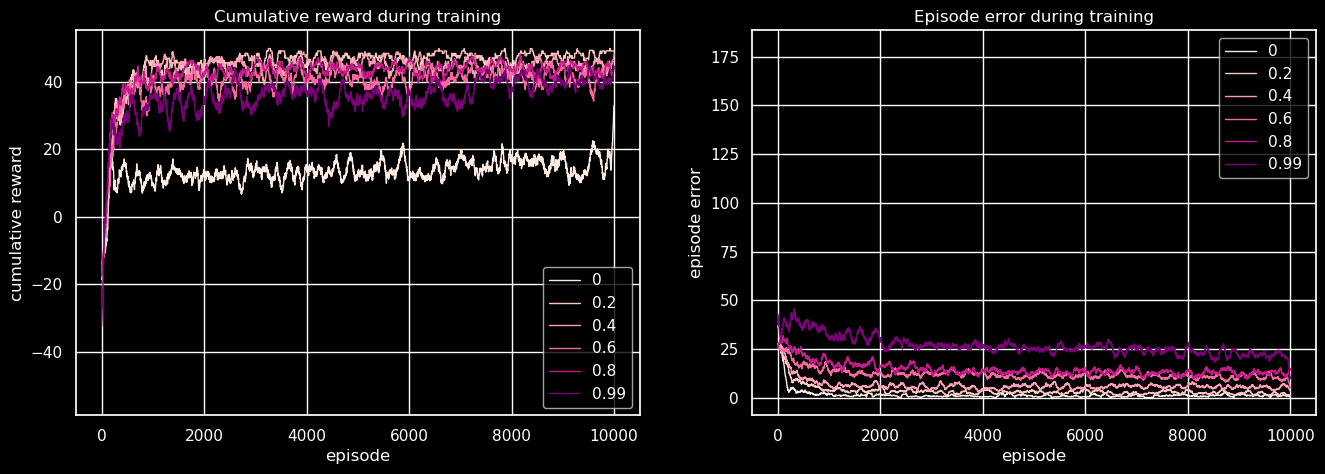

In [22]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

### SARSA($\lambda$)

In [33]:
class SARSA:
    def __init__(self, env, gamma, lmbda, alpha=1., N0=1):
        self.env   = env
        self.gamma = gamma
        self.lmbda = lmbda
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=1000):
        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        for _ in tqdm(range(max_episodes)):
            
            Etable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

            state, done = self.env.reset(random_init = True)
            action = policy.act(state, epsilon=1)

            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                Etable[state][action] = Etable[state][action] + 1

                next_state, reward, done, info = self.env.step(action)

                epsilon = self.N0 / (self.N0 + sum(Ntable[next_state].values()))

                next_action = policy.act(next_state, epsilon)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * policy.Q(next_state, next_action) - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = self.alpha/Ntable[state][action]

                for state in Etable:
                    for action in Actions.actions:
                        policy.update_Q(state, action, alpha, td_error * Etable[state][action])
                        Etable[state][action] *= self.gamma * self.lmbda

                state  = next_state
                action = next_action

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(self.env.is_win())
        
        return policy, history

In [34]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyQAgent(),
    SARSA(deterministic_env.set_render(None), 0.99, 0),
    "lmbda",
    [0, 0.2, 0.4, 0.6, 0.8, 1]
)

performance

100%|██████████| 10000/10000 [02:08<00:00, 77.60it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.0,45.0,5.0,1.0,8.436682
0.2,45.0,5.0,1.0,9.22951
0.4,43.0,7.0,1.0,10.253334
0.6,-102.0,101.0,0.0,131.908534
0.8,-134.0,101.0,0.0,135.294898
1.0,-167.0,101.0,0.0,128.87234


In [35]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Classic", "SARSA"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682

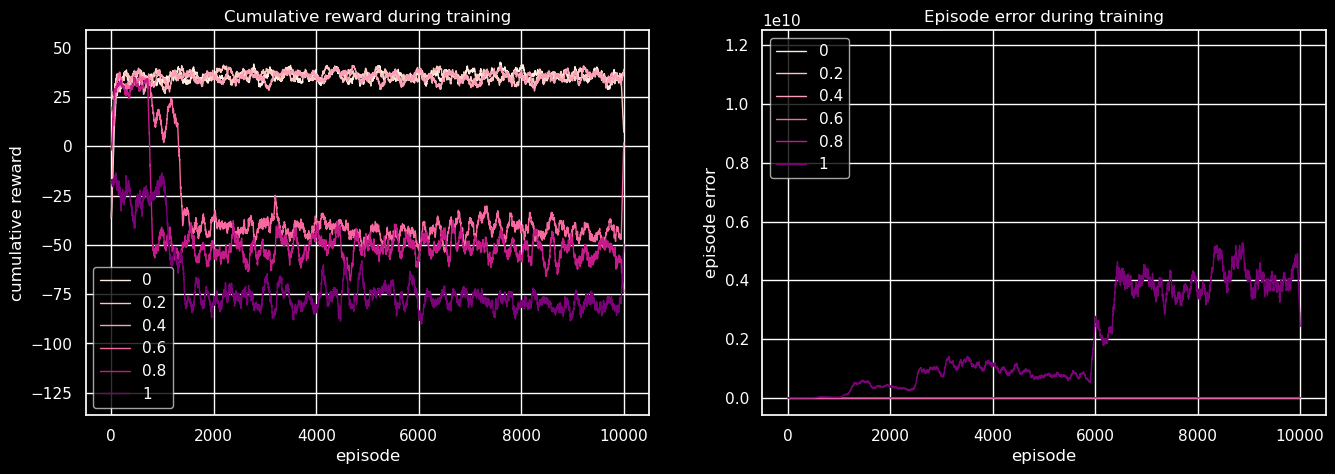

In [36]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [37]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyQAgent(),
    SARSA(stochastic_env.set_render(None), 0.99, 0),
    "lmbda",
    [0, 0.2, 0.4, 0.6, 0.8, 1]
)

performance

100%|██████████| 10000/10000 [01:12<00:00, 137.60it/s]


,Mean reward,Mean length,Mean winrate,Training time
0.0,12.86,5.6,0.55,11.786516
0.2,42.46,7.54,1.0,10.721102
0.4,32.39,13.92,0.95,13.671
0.6,21.86,19.13,0.85,60.509477
0.8,2.02,29.22,0.76,22.205707
1.0,-56.63,35.48,0.0,72.674193


In [38]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Classic", "SARSA"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

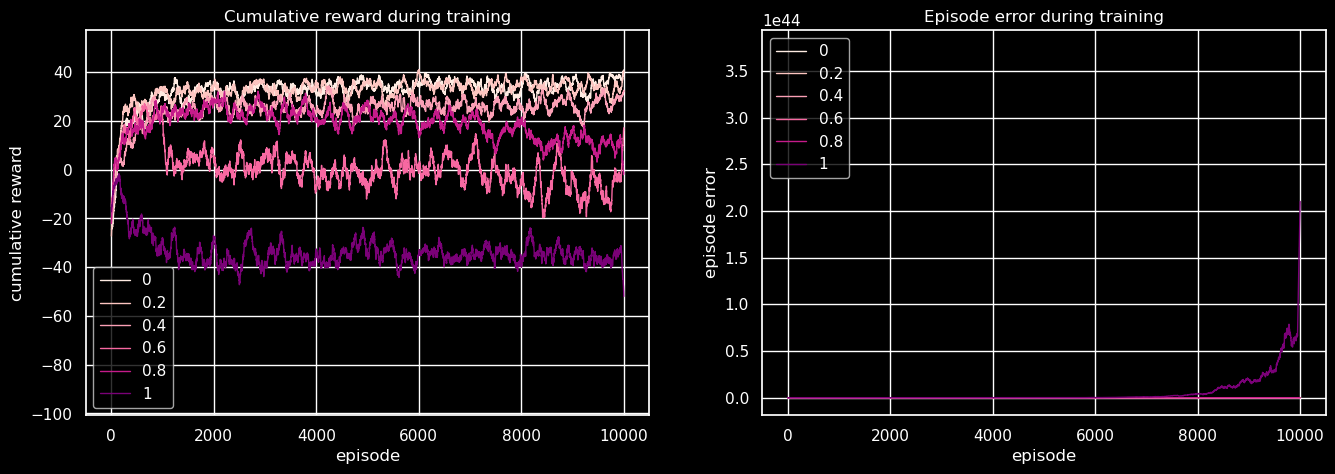

In [39]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

## Linear Features

In [43]:
deterministic_env = PacmanEnv.contourDanger(4, ghost_names= "RobustGhost", state_space="features")
stochastic_env    = PacmanEnv.contourDanger(4, ghost_names= "StochasticRobustGhost", state_space="features")

In [48]:
class EpsilonGreedyLinearAgent(Agent):
    """
    Agent with linear approximation for Q and epsilon-greedy policy.
    This class do not include any default training algorithm.
    """

    def __init__(self, state_dim):
        self.state_dim = state_dim

        self.weights = np.random.rand(state_dim)
        self.bias    = np.random.rand(1)
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action, _ = self.max_Q(state)

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        idx = Actions.action_index(action)

        return self.bias + np.dot(np.array(state)[idx], self.weights)


    def max_Q(self, state):
        Qvalues = np.array(state) @ self.weights + self.bias

        idx = np.argmax(Qvalues)

        return Actions.actions[idx], Qvalues[idx]


    def update_Q(self, state, action, alpha, error):
        idx = Actions.action_index(action)

        bellman_loss_grad = np.array(state)[idx]

        self.weights += alpha * error * bellman_loss_grad
        self.bias    += alpha * error
    
    def reset(self):
        self.weights = np.random.rand(self.state_dim)
        self.bias    = np.random.rand(1)
    

#### Monte Carlo

In [46]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyLinearAgent(5),
    MonteCarloControl(deterministic_env.set_render(None), 0.99),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

100%|██████████| 10000/10000 [03:10<00:00, 52.56it/s]


AttributeError: 'EpsilonGreedyLinearAgent' object has no attribute 'reset'

In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Linear", "Monte Carlo"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

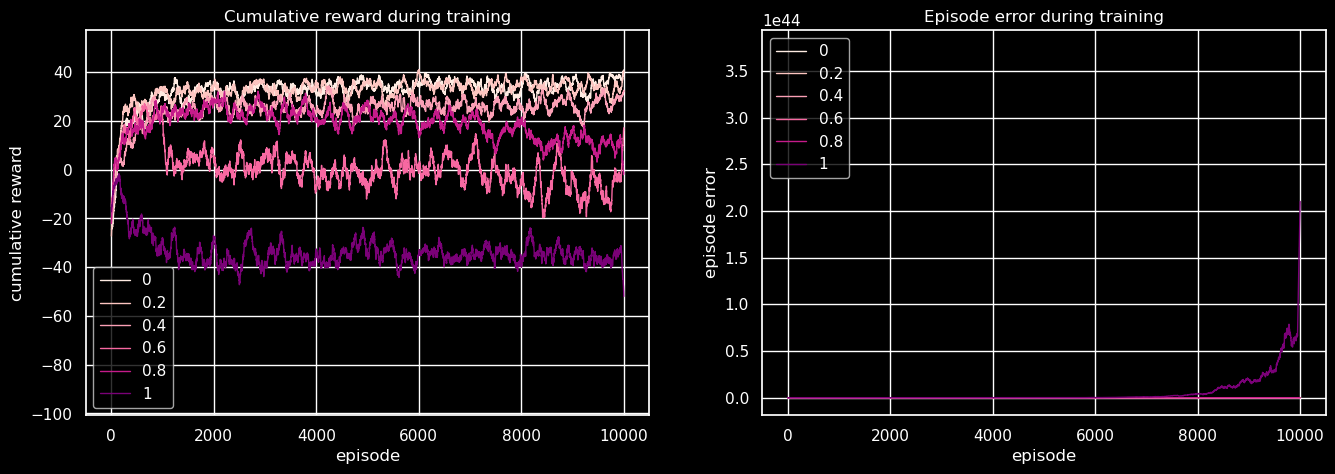

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyLinearAgent(5),
    MonteCarloControl(stochastic_env.set_render(None), 0.99),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Linear", "Monte Carlo"), :] = performance.iloc[best]

results

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

#### Q-Learning

In [ ]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyLinearAgent(5),
    QLearning(deterministic_env.set_render(None), 0.99),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

100%|██████████| 10000/10000 [03:10<00:00, 52.56it/s]


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Linear", "Q-Learning"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

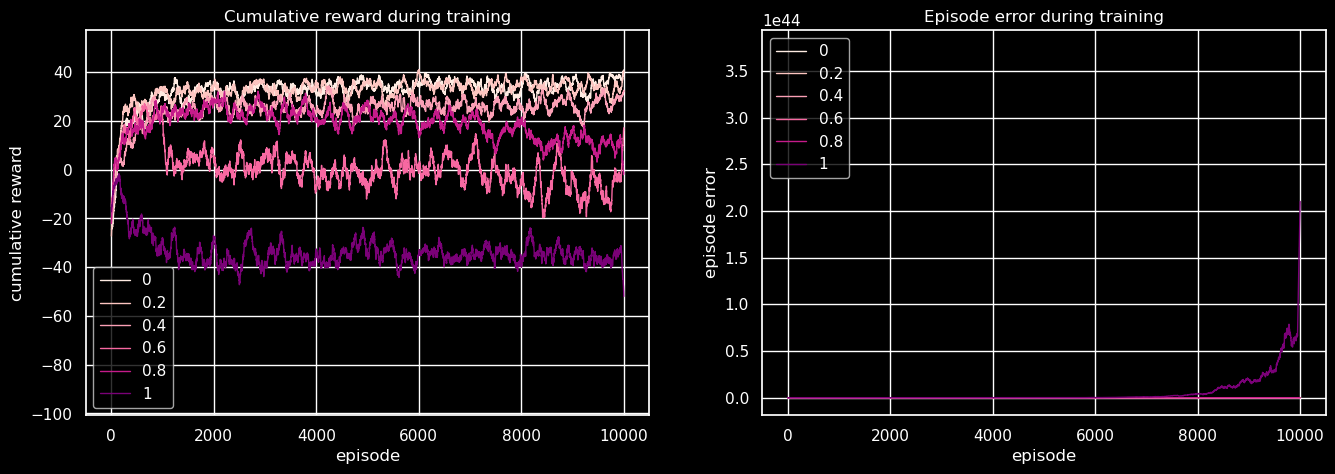

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyLinearAgent(5),
    QLearning(stochastic_env.set_render(None), 0.99),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Linear", "Q-Learning"), :] = performance.iloc[best]

results

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

#### SARSA

In [ ]:
history, performance = evaluate(
    deterministic_env,
    EpsilonGreedyLinearAgent(5),
    SARSA(deterministic_env.set_render(None), 0.99, 0.2),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

100%|██████████| 10000/10000 [03:10<00:00, 52.56it/s]


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Linear", "SARSA"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

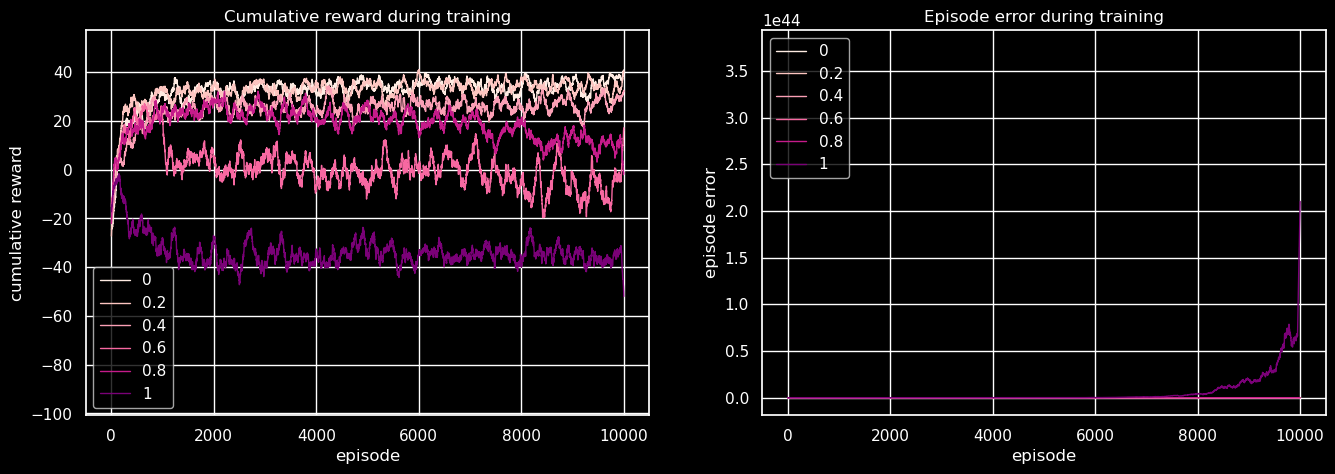

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    EpsilonGreedyLinearAgent(5),
    SARSA(stochastic_env.set_render(None), 0.99, 0.2),
    "alpha",
    [0.1, 0.01, 0.001, 0.0001]
)

performance

In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Linear", "SARSA"), :] = performance.iloc[best]

results

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

## Deep Reinforcement Learning

In [ ]:
deterministic_env = PacmanEnv.contourDanger(4, ghost_names= "RobustGhost", state_space="pixel")
stochastic_env    = PacmanEnv.contourDanger(4, ghost_names= "StochasticRobustGhost", state_space="pixel")

state_dim = deterministic_env.height * deterministic_env.width * 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DeepQ(nn.Module):
    def __init__(self, state_dim, action_dim) -> None:
        super().__init__()

        self.input_layer  = nn.Linear(state_dim, 64)
        self.hidden_layer = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, action_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = F.relu(x)
        x = self.output_layer(x)

        return x


class DeepAgent(Agent):
    """
    Agent with a  for Q and epsilon-greedy policy.
    This class do not include any default training algorithm.
    """

    def __init__(self, state_dim, action_dim, update_frequency):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.net = DeepQ(state_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        self.update_step = 0
        self.update_frequency = update_frequency
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action, _ = self.max_Q(state)

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        idx = Actions.action_index(action)

        state = torch.tensor(state).float()
        return self.net(state)[idx]


    @torch.no_grad()
    def max_Q(self, state):
        state = torch.tensor(state).float()

        Qvalues = self.net(state)

        idx = np.argmax(Qvalues)

        return Actions.actions[idx], Qvalues[idx]


    def update_Q(self, state, action, alpha, error):
        self.loss = 1/2 * error**2 / self.update_frequency

        self.loss.backward() 

        if (self.update_step + 1) % self.update_frequency:
            self.optimizer.step()
            self.optimizer.zero_grad()
        
        self.update_step += 1
    
    def reset(self):
        self.net = DeepQ(self.state_dim, self.action_dim)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.0001)

        self.update_step = 0

In [ ]:
history, performance = evaluate(
    deterministic_env,
    DeepAgent(state_dim, 4, 1),
    QLearning(deterministic_env.set_render(None), 0.99),
    "update_frequency",
    [1, 4, 16, 32, 64, 128]
)

performance

100%|██████████| 10000/10000 [03:10<00:00, 52.56it/s]


In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Deterministic", "Deep", "Q-Learning"), :] = performance.iloc[best]

results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning         45.0         5.0          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning       6.692488  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102

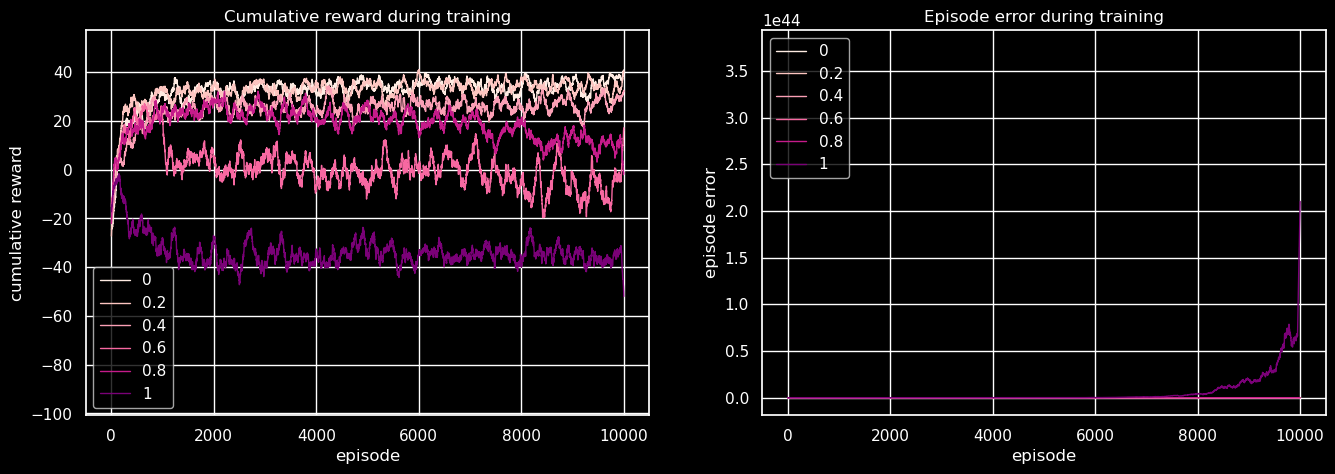

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [ ]:
history, performance = evaluate(
    stochastic_env,
    DeepAgent(state_dim, 4, 1),
    QLearning(stochastic_env.set_render(None), 0.99),
    "update_frequency",
    [1, 4, 16, 32, 64, 128]
)

performance

In [ ]:
best = performance["Mean reward"].to_numpy().argmax()

results.loc[("Stochastic", "Deep", "Q-Learning"), :] = performance.iloc[best]

results

In [ ]:
plot_episodes(history, ['cumulative reward', 'episode error'],  alpha=0)
plt.show()

In [49]:
results

Mean reward Mean length Mean winrate  \
Environment   Policy  Algorithm                                          
Deterministic Classic Monte Carlo        45.0         5.0          1.0   
Stochastic    Classic Monte Carlo       39.72        9.69          1.0   
Deterministic Classic Q-Learning        42.46        7.54          1.0   
                      SARSA              45.0         5.0          1.0   
Stochastic    Classic SARSA             42.46        7.54          1.0   

                                  Training time  
Environment   Policy  Algorithm                  
Deterministic Classic Monte Carlo     29.486002  
Stochastic    Classic Monte Carlo      8.997007  
Deterministic Classic Q-Learning      10.721102  
                      SARSA            8.436682  
Stochastic    Classic SARSA           10.721102